In [1]:
import numpy as np
import pandas as pd
from statsbombpy import sb
import networkx as nx
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch
import statistics as stats

In [2]:
#Import competition data to find season we are interested in: La Liga - 2020/2021
competition_df = sb.competitions()
season = competition_df[ (competition_df.competition_name == 'La Liga') & (competition_df.season_name == '2020/2021') ]

In [3]:
#Find the matches where Barcelona played. Could be as home team or away team
season_matches = sb.matches(competition_id = season.competition_id.iloc[0],season_id = season.season_id.iloc[0])
barcelona_matches = season_matches[ (season_matches.home_team == 'Barcelona') | ( season_matches.away_team == 'Barcelona') ]
#Note that matches are not in date order
sb.events(barcelona_matches.match_id[0]).columns

Index(['ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_other', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_penalty', 'foul_won_advantage',
       'foul_won_defensive', 'foul_won_penalty', 'goalkeeper_body_part',
       'goalkeeper_end_location', 'goalkeeper_outcome', 'goalkeeper_position',
       'goalkeeper_technique', 'goalkeeper_type', 'id', 'index',
       'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_end_location', 'pass_goal_assist', 'pass_hei

In [4]:
# def attack_graph()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.8/site-packages/mplsoccer/_pitch_base.py:427: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

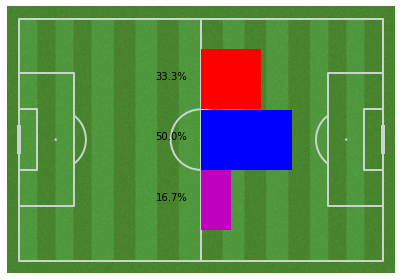

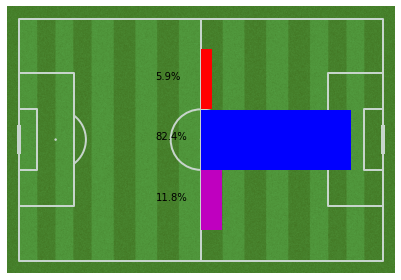

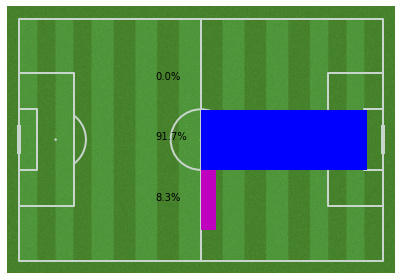

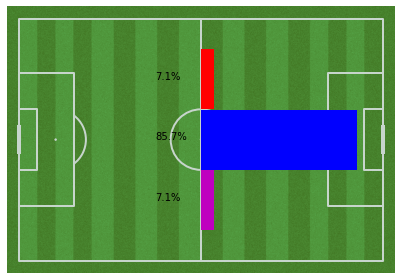

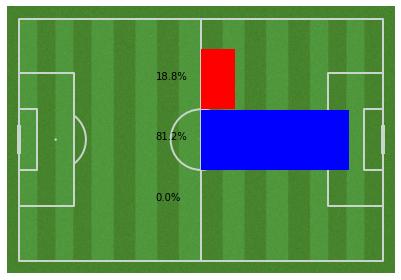

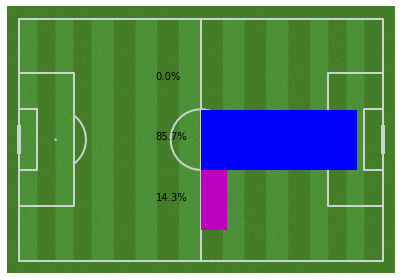

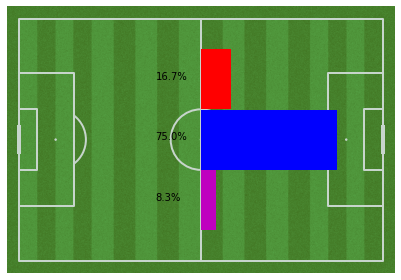

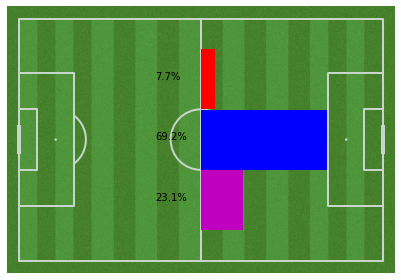

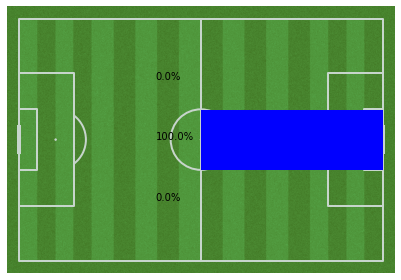

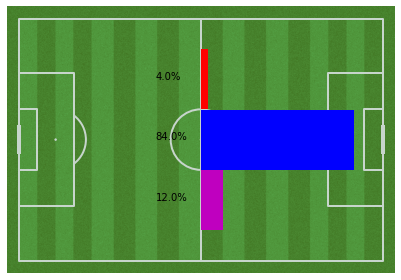

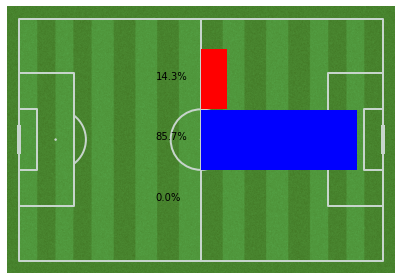

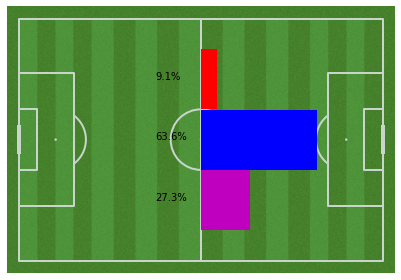

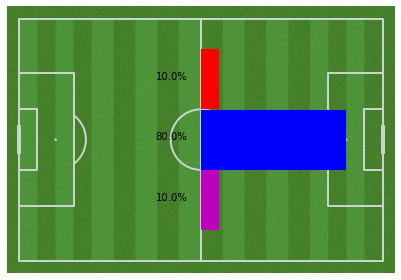

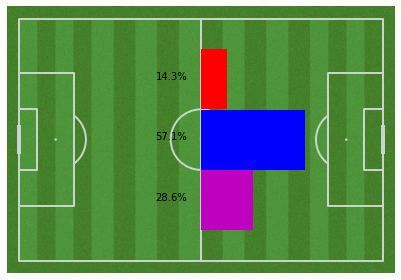

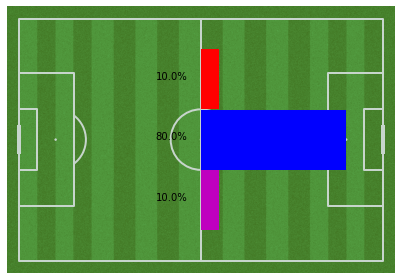

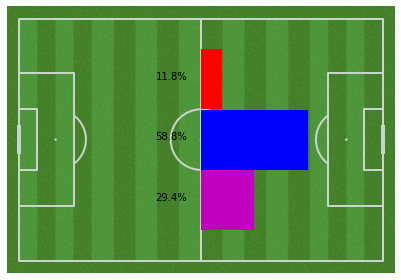

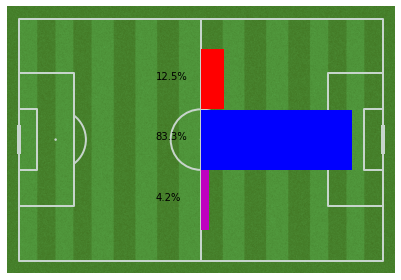

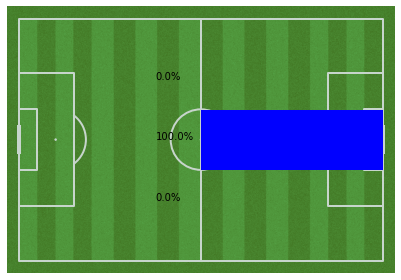

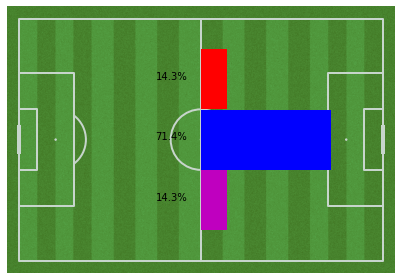

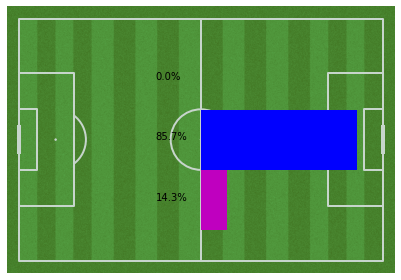

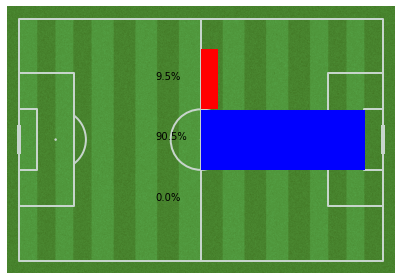

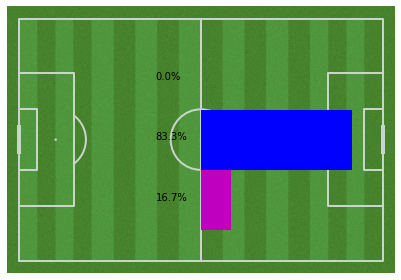

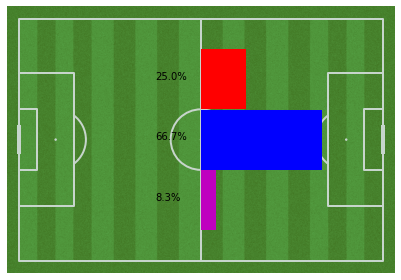

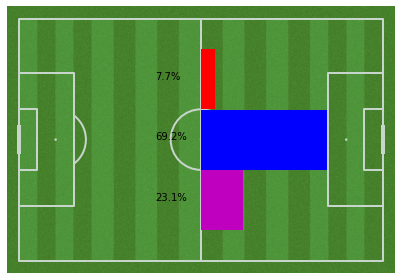

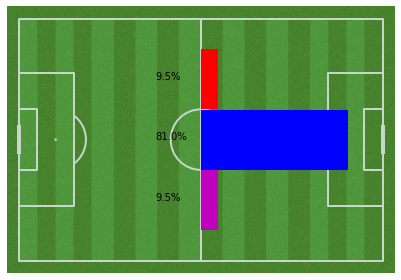

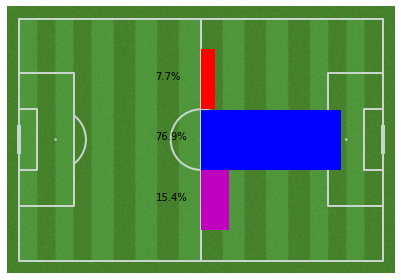

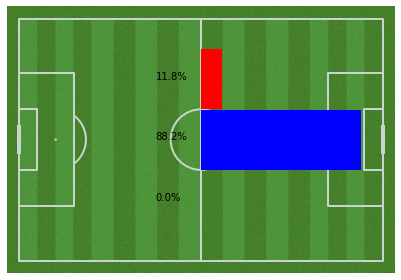

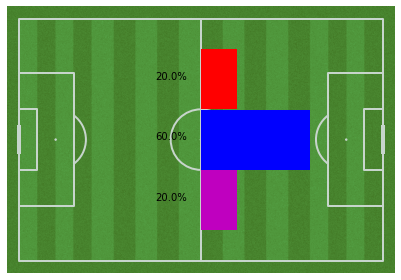

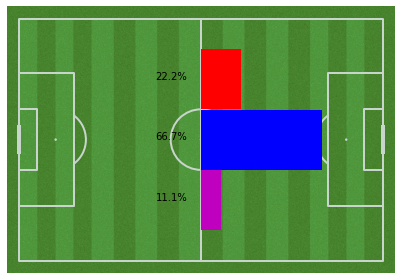

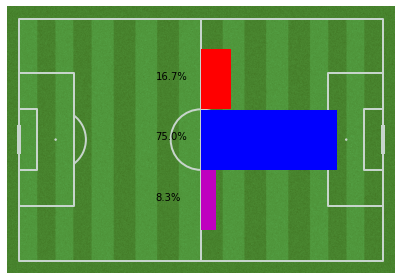

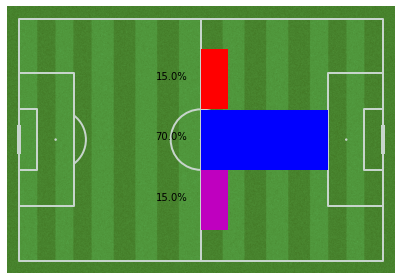

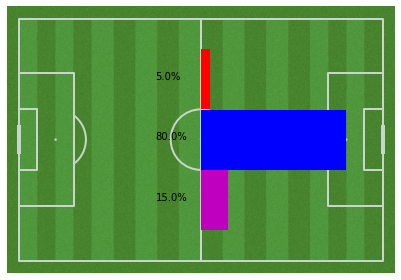

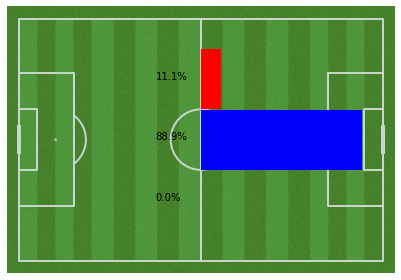

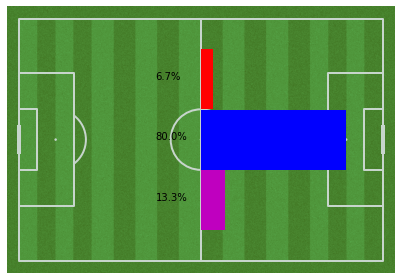

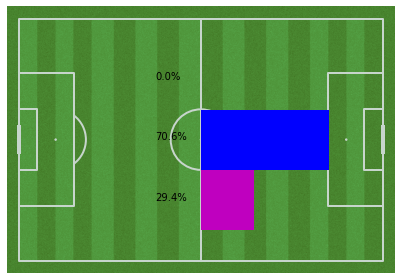

In [5]:
# shot_minute = pd.DataFrame()

left_list = []
mid_list=[]
right_list=[] 



#Iterates through each match and finds the barca shots, records the minute, second and what possesion it was in
for match_id_iter in barcelona_matches.match_id:
    shot_minute = pd.DataFrame()
    match_iter = sb.events(match_id=match_id_iter)
    shots = match_iter[(match_iter.type == 'Shot') & (match_iter.team == 'Barcelona')]
    shot_minute = pd.concat([shot_minute, shots[['minute','second','possession']]], ignore_index=True)
    #Creates new data frames, dont know if this is necessary
    previous_events = pd.DataFrame()

    
    # ten_previous_events = pd.DataFrame()
    # ten_previous_events['y_location'] = np.nan
    attack_mean_list = []
    #Iterates through each shot event and find the events in an entire minute previous, ONLY COUNTS THE EVENTS IF THEY WERE IN THE SAME 'POSSESSION'
    for i,row in shot_minute.iterrows():
        
        ten_previous_events = pd.DataFrame()
        ten_previous_events['y_location'] = np.nan

        previous_events = match_iter[(((match_iter.minute == row.minute) & (match_iter.second <= row.second )) | ((match_iter.minute == (row.minute - 1)) & (match_iter.second >= row.second ))) & (match_iter.possession == row.possession)]
        #Finding length of this list to allow for loop
        pe_length = len(previous_events.index)
        #For loop finds the last x events unless the previous events have less than x entries
        x = 3

        #If loop solves specific bugs for if pe_length == 1 or is less than x
        if pe_length == 1:
            
            ten_previous_events = previous_events.iloc[0]
            
        elif pe_length< x:
        
            ten_previous_events = previous_events.iloc[-pe_length:-1]
        else:
            ten_previous_events = previous_events.iloc[-x:-1]

        #If loop solves specific bugs for if pe_length == 1
        if pe_length ==1:
            y_loc_mean = ten_previous_events.location[1]
            attack_mean_list.append(y_loc_mean)
        else:
            for j,row in ten_previous_events.iterrows():
                #Finds y coordinate for the previous events and adds them to a new feature
                ten_previous_events.loc[j,'y_location'] = row.location[1]

            y_loc_mean = ten_previous_events.y_location.mean()
            attack_mean_list.append(y_loc_mean)


    
    # Creates counter for what direction an attack is coming from
    left = 0
    middle = 0
    right = 0

    num_shots = len(attack_mean_list)
    for i in range(num_shots):
        if attack_mean_list[i] <= (80/3):
            left +=1
        elif (80/3)<attack_mean_list[i]<=(160/3):
            middle +=1
        else:
            right +=1

    left_av = left/num_shots
    middle_av = middle/num_shots
    right_av = right/num_shots
    
    left_list.append(left_av)
    mid_list.append(middle_av)
    right_list.append(right_av)
    
    # Plotting pitch and bars
    
    pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
            pitch_color='grass', line_color='#c7d5cc', figsize=(13.5, 8),
            constrained_layout=True, stripe=True, tight_layout=False)
    fig, ax = pitch.draw()

    plt.plot((60,(60+(left_av*60))),(20,20),'r',linewidth=60,solid_capstyle='butt')
    plt.plot((60,(60+(middle_av*60))),(40,40),'b',linewidth=60,solid_capstyle='butt')
    plt.plot((60,(60+(right_av*60))),(60,60),'m',linewidth=60,solid_capstyle='butt')

    x_lab = 45
    y_lab = [20,40,60]
    percent_labels = [str(round(left_av*100,1))+'%',str(round(middle_av*100,1))+'%',str(round(right_av*100,1))+'%']

    for i,txt in enumerate(percent_labels):
        ax.annotate(txt,[x_lab,y_lab[i]])










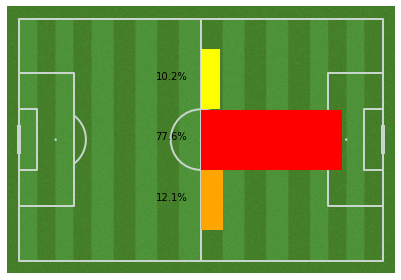

In [14]:
#Same code as above but sums all the results as an average for the season


season_left_av = np.mean(left_list)
season_mid_av = np.mean(mid_list)
season_right_av = np.mean(right_list)

pitch = Pitch(pitch_type='statsbomb', orientation='horizontal',
        pitch_color='grass', line_color='#c7d5cc', figsize=(13.5, 8),
        constrained_layout=True, stripe=True, tight_layout=False)
fig, ax = pitch.draw()

plt.plot((60,(60+(season_left_av*60))),(20,20),'#FFFF00',linewidth=60,solid_capstyle='butt')
plt.plot((60,(60+(season_mid_av*60))),(40,40),'r',linewidth=60,solid_capstyle='butt')
plt.plot((60,(60+(season_right_av*60))),(60,60),'#FFA500',linewidth=60,solid_capstyle='butt')
# plt.title('Season Average for Build ups leading to a shot')

x_lab = 45
y_lab = [20,40,60]
percent_labels = [str(round(season_left_av*100,1))+'%',str(round(season_mid_av*100,1))+'%',str(round(season_right_av*100,1))+'%']

for i,txt in enumerate(percent_labels):
    ax.annotate(txt,[x_lab,y_lab[i]])
plt.savefig('attack_driection_graph.png')
plt.show()
